In [1]:
import pandas as pd

import pandas as pd

import numpy as np
import seaborn as sns
import sys
import json
import ast
import numdifftools as nd
from joblib import Parallel, delayed
from autograd import hessian
import os
import autograd.numpy as np  # Autograd-compatible numpy
from autograd.scipy.stats import norm  # Autograd-compatible normal distribution functions
from autograd import grad, hessian  

import matplotlib.image as mpimg
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

%load_ext autoreload

%autoreload 2

sys.path.append("../")
from protocols import utils

import warnings

In [2]:

mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()

#read in the mutations tables, subsetted down to BDQ WHO-defined candidate genes
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()
#GARC mutation naming
mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
#flag sysnonymous mutations
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
#flag null calls
mutations["IS_NULL"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1]  == 'Z'
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)
#fill in nucleotide indexes for mmpL5 
gene_positions = {'Rv0678':778990, 'mmpL5':775586, 'pepQ':2859300, 'atpE':1461045, 'mmpS5':778477 }
mutations['NUCLEOTIDE_INDEX'] = mutations.apply(
    lambda row: gene_positions[row['GENE']] + 
                (row['NUCLEOTIDE_NUMBER'] if pd.notna(row['NUCLEOTIDE_NUMBER']) else row['GENE_POSITION']),
    axis=1
)

#read in table of genomes
genomes = pd.read_csv("./data/GENOMES.csv.gz").reset_index()

mutations = mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])]

#read in cyrptic samples
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz").reset_index()
phenotypes_cryptic_samples = set(phenotypes_cryptic.UNIQUEID)
#filter for high quality phenotypes from UKMYC5 and UKMYC6 plates
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.UNIQUEID.isin(genomes.UNIQUEID)]

assert phenotypes_cryptic.UNIQUEID.nunique() == len(phenotypes_cryptic.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in new nicd samples
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz").reset_index()
phenotypes_nicd_samples = set(phenotypes_nicd.UNIQUEID)
#filter for mgit samples
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].UNIQUEID
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(has_mgit)]
#filter for samples with genomes
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(genomes.UNIQUEID)]
# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)

#combine cryptic and nicd phenotype tables
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutually exclusive!"
phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 
assert phenotypes.UNIQUEID.nunique() == len(phenotypes.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in growth data of the cryptic plates
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

samples = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])

all = pd.merge(mutations, samples, how='right', on=['UNIQUEID'])
all.dropna(subset=['METHOD_MIC'], inplace=True)
all['GENE'].fillna('None', inplace=True)

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

In [3]:
all['MUTATION'] = all.apply(
    lambda row: f"{row['GENE']}@{int(row['GENE_POSITION'])}_indel" 
    if (pd.notna(row['GENE_POSITION']) and ('ins' in row['MUTATION'] or 'del' in row['MUTATION']))
    else row['MUTATION'], 
    axis=1
)

In [4]:
synonymous_mgit = []
synonymous_plate = []
wt_mgit = []
wt_plate = []

for i in all.UNIQUEID.unique():
    df = all[all.UNIQUEID == i]
    if df.METHOD_2.iloc[0] == 'MGIT':
        if len(df) == 1 and df.IS_SYNONYMOUS.iloc[0] == True:
            synonymous_mgit.append(df.UNIQUEID.iloc[0])
        elif pd.isna(df.MUTATION.iloc[0]):  
            wt_mgit.append(df.UNIQUEID.iloc[0])
    else:
        if len(df) == 1 and df.IS_SYNONYMOUS.iloc[0] == True:
            synonymous_plate.append(df.UNIQUEID.iloc[0])
        elif pd.isna(df.MUTATION.iloc[0]):
            wt_plate.append(df.UNIQUEID.iloc[0])

mgit_wts = all[all.UNIQUEID.isin(synonymous_mgit+wt_mgit)]
plate_wts = all[all.UNIQUEID.isin(synonymous_plate+wt_plate)]

mgit_mutants = all[(all.METHOD_2=='MGIT')&(~all.UNIQUEID.isin(synonymous_mgit+wt_mgit))]
plate_mutants = all[(all.METHOD_2=='microdilution plate')&(~all.UNIQUEID.isin(synonymous_plate+wt_plate))]
mgit = pd.concat([mgit_mutants, mgit_wts])

In [5]:
mgit_wts.METHOD_MIC.value_counts()

0.5        50
0.25       32
1          26
2          13
<=0.125    12
4          10
8           5
Name: METHOD_MIC, dtype: int64

In [6]:
def process_mic_data(df):
    y_low = []
    y_high = []

    dilution_factor = 2
    tail_dilution_factor = dilution_factor ** 3 #3 doubling dilutions (or 3 log2MICs) censored extension on either side

    for mic in df['METHOD_MIC']:
        if mic.startswith('<='):
            lower_bound = float(mic[2:])
            y_low.append(lower_bound / tail_dilution_factor)  # Adjust for left-censoring
            y_high.append(lower_bound)
        elif mic.startswith('>'):
            upper_bound = float(mic[1:])
            y_low.append(upper_bound)
            y_high.append(upper_bound * tail_dilution_factor)  # Adjust for right-censoring
        else:
            # For exact MIC values, the interval is MIC - 1 doubling dilution
            mic_value = float(mic)
            y_low.append(mic_value / dilution_factor)
            y_high.append(mic_value)
            
    return np.round(np.array(y_low), 3), np.round(np.array(y_high), 3)

In [7]:
def log_likelihood_mixed_effects(params, y_low, y_high, X, clusters):
    beta = params[:X.shape[1]]  # Fixed effects
    u = params[X.shape[1]:-1]  # Random effects for clusters
    sigma = params[-1]  # Standard deviation

    # Predicted mean for each sample
    mu = np.dot(X, beta) + u[clusters]  # Use cluster numeric IDs for random effects

    log_L = 0

    # Likelihood for left-censored values
    left_censored = y_low == -5.96578428
    if np.any(left_censored):
        log_L += np.sum(norm.logcdf((y_high[left_censored] - mu[left_censored]) / sigma))

    # Likelihood for right-censored values
    right_censored = (y_high == 4) | (y_high == 6)
    if np.any(right_censored):
        log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu[right_censored]) / sigma)))

    # Likelihood for interval-censored values
    interval_censored = ~left_censored & ~right_censored & (y_low != y_high)
    if np.any(interval_censored):
        log_L += np.sum(
            np.log(
                norm.cdf((y_high[interval_censored] - mu[interval_censored]) / sigma)
                - norm.cdf((y_low[interval_censored] - mu[interval_censored]) / sigma)
            )
        )

    return -log_L  # Minimize the negative log-likelihood

In [8]:
#all_mutations = pd.read_pickle('/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/cryptic-tables-v2.1.1/MUTATIONS.pkl.gz').reset_index()
#all_mutations = all_mutations[all_mutations.UNIQUEID.isin(mgit.UNIQUEID)]
#all_mutations.to_csv('./data/ignore/bdq_all_samples.csv')

In [9]:
# Random effects - need to generate Z matrix, which represents the genomic cluster id random effect variable
# shape = (samples, n_clusters), with OHE membership to columns (cluster id flags, basically)
# need to caslculate whole-genome snp distances - therefore need wider MUTATIONS table, but will filter down to relevant isolates


def cluster_coordinates(mutations_df, samples_df, distance):

    all_mutations = mutations_df
    
    all_mutations.dropna(subset="ALT", inplace=True)
    all_mutations["SNP_ID"] = (
        all_mutations["GENE"]
        + "_"
        + all_mutations["GENE_POSITION"].astype(str)
        + "_"
        + all_mutations["REF"]
        + "_"
        + all_mutations["ALT"]
    )

    # Build the SNP matrix (binary matrix where 1 = mutation, 0 = no mutation)
    snp_matrix = pd.pivot_table(
        all_mutations,
        index="UNIQUEID",
        columns="SNP_ID",
        aggfunc="size",
        fill_value=0
    )

    snp_matrix = snp_matrix.applymap(lambda x: 1 if x > 0 else 0)

    # Include all UNIQUEIDs from the original dataset (to ensure WT samples are included)
    unique_ids = samples_df["UNIQUEID"].unique()
    snp_matrix = snp_matrix.reindex(unique_ids, fill_value=0)

    # Calculate pairwise distances (Hamming distance)
    dist_matrix = pairwise_distances(snp_matrix, metric='hamming')

    # Perform Agglomerative Clustering on the distance matrix
    agg_cluster = AgglomerativeClustering(
        metric='precomputed',
        linkage='complete',
        distance_threshold=distance/len(snp_matrix.columns),  # Hamming threshold conversion
        n_clusters=None
    )

    # Cluster IDs for samples with mutations
    cluster_ids = agg_cluster.fit_predict(dist_matrix)

    return cluster_ids



In [10]:


#create Z matrix (n_samples, n_clusters (ohe))
#n_samples = len(cluster_ids)
#n_clusters = np.unique(cluster_ids).size

# Initialize the Z matrix with zeros
#Z = np.zeros((n_samples, n_clusters))

# Populate the Z matrix
#for i in range(n_samples):
    #Z[i, cluster_ids[i]] = 1

#print ('Random effects matrix:', Z.shape)

In [11]:
#Fixed effects:

#siteid and lineage:

#siteids = pd.get_dummies(mgit_mutants['SITEID'], drop_first=True)
#X = siteids.values

#mutation matrix and interaction terms:

# pivot the DataFrame to create a binary matrix where rows = samples and columns = unique non-synonymous  mutations
def build_X(df):
    
    # Get all unique IDs from the input DataFrame
    unique_ids = df['UNIQUEID'].unique()

    mut_matrix = pd.pivot_table(
        df,
        index="UNIQUEID",
        columns="MUTATION",
        aggfunc="size",  # counts occurrences
        fill_value=0,    # absence of the mutation
    )

    mut_matrix = mut_matrix.applymap(lambda x: 1 if x > 0 else 0)
    #reindex the matrix to ensure all unique IDs are present, even if they have no mutations
    mut_matrix = mut_matrix.reindex(unique_ids, fill_value=0)

    return mut_matrix



#include interation terms for pairs of mutations that co occur 5 or more times

'''mutation_counts = (mut_matrix.sum(axis=0) >= 2)
valid_mutations = mutation_counts[mutation_counts].index

pair_counts = (mut_matrix[valid_mutations].T @ mut_matrix[valid_mutations])
pair_counts = np.tril(pair_counts, -1)  # Use lower triangle to avoid duplicates

valid_pairs = np.argwhere(pair_counts >= 2)
mutation_pairs = [(valid_mutations[i], valid_mutations[j]) for i, j in valid_pairs]

for mut1, mut2 in mutation_pairs:
    interaction_col = mut_matrix[mut1] * mut_matrix[mut2]
    X[f'{mut1}_x_{mut2}'] = interaction_col'''


"mutation_counts = (mut_matrix.sum(axis=0) >= 2)\nvalid_mutations = mutation_counts[mutation_counts].index\n\npair_counts = (mut_matrix[valid_mutations].T @ mut_matrix[valid_mutations])\npair_counts = np.tril(pair_counts, -1)  # Use lower triangle to avoid duplicates\n\nvalid_pairs = np.argwhere(pair_counts >= 2)\nmutation_pairs = [(valid_mutations[i], valid_mutations[j]) for i, j in valid_pairs]\n\nfor mut1, mut2 in mutation_pairs:\n    interaction_col = mut_matrix[mut1] * mut_matrix[mut2]\n    X[f'{mut1}_x_{mut2}'] = interaction_col"

Issue is - the NICD WT samples all have the same SITEID (and we dont have lineage data) - therefore, cant really had the fixed effects for this. But in essence, do the above and concat the various fixed effect matrixes together.

In [12]:

# Initialize the scaler
#scaler = StandardScaler()
# Fit the scaler to y_low_log and y_high_log
#y_low_log = scaler.fit_transform(y_low_log.reshape(-1, 1)).flatten()
#y_high_log = scaler.transform(y_high_log.reshape(-1, 1)).flatten()


In [13]:
def predicted_effects(result, X, p):
    # Extract only the first p elements of the result, which correspond to the mutation effects
    fixed_effects_coefficients = result.x[:p]

    # Sigma (standard deviation)
    sigma = result.x[-1]

    # Create DataFrame for mutation effects
    mutation_effects = pd.DataFrame({
        'Mutation': X.columns,  # The names of the mutations from X
        'Effect_Size': fixed_effects_coefficients
    })

    # Convert effect sizes to MIC values (by reversing the log transformation)
    mutation_effects['MIC'] = 2**mutation_effects['Effect_Size']

    if hasattr(result, 'hess_inv'):
        hess_inv_dense = result.hess_inv.todense()  # Convert to a dense matrix
        # Extract the diagonal elements corresponding to the fixed effects (log2(MIC) scale)
        effect_std_log2 = np.sqrt(np.diag(hess_inv_dense)[:p])  # Standard deviation of log2(MIC)
        mutation_effects['Effect_Std'] = effect_std_log2
        # Convert standard deviation to MIC scale
        mutation_effects['MIC_Std'] = mutation_effects['MIC'] * np.log(2) * mutation_effects['Effect_Std']
        mutation_effects = mutation_effects[['Mutation', 'Effect_Size', 'Effect_Std', 'MIC', 'MIC_Std']]
    else:
        mutation_effects = mutation_effects[['Mutation', 'Effect_Size', 'MIC']]

    return mutation_effects




## Fit model to mutants only

In [15]:
#random effects
#all_mutations = pd.read_pickle('/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/cryptic-tables-v2.1.1/MUTATIONS.pkl.gz').reset_index()
#all_mutations = all_mutations[all_mutations.UNIQUEID.isin(mgit_mutants.UNIQUEID)]
#all_mutations.to_csv('./data/ignore/bdq_all_mutations.csv')

all_mutations = pd.read_csv("./data/ignore/bdq_all_mutations.csv", index_col=0)
cluster_ids = cluster_coordinates(all_mutations, mgit_mutants, distance=25)

X = build_X(mgit_mutants)
#convert sample MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(mgit_mutants.drop_duplicates(subset='UNIQUEID', keep='first'))
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))

#initialise coefficients and standard deviation
# Number of fixed effects
p = X.shape[1]

# Number of random effects (equal to number of unique clusters)
#r = Z.shape[1]

n_clusters = len(np.unique(cluster_ids))
initial_random_effects = np.zeros(n_clusters)  # One random effect per cluster

initial_beta = np.random.normal(loc=0, scale=0.5, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)

# Combine initial values for the parameters
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

fixed_effect_bounds = [(-6, 6)] * X.shape[1]
random_effect_bounds = [(None, None)] * n_clusters
sigma_bound = [(1e-5, None)]
bounds = fixed_effect_bounds + random_effect_bounds + sigma_bound


In [16]:

result_tc = minimize(
    log_likelihood_mixed_effects, 
    initial_params, 
    args=(y_low_log, y_high_log, X, cluster_ids),
    method='trust-constr',
    bounds=bounds,  # Sigma must be positive
    options={        'maxiter': 10000,          # Maximum iterations
        'gtol': 1e-2,             # Tolerance for gradient norm (similar to tol)
        'xtol': 1e-6,             # Tolerance for step size changes
        'barrier_tol': 1e-6,      # Barrier method tolerance
        'verbose': 3   }  # Increase the max iterations and function evaluations
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  657  |   0   | +1.0994e+03 | 1.00e+00 | 5.10e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   | 1314  |   1   | +9.2699e+02 | 2.00e+00 | 7.29e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   | 1971  |   3   | +9.1717e+02 | 1.12e+01 | 4.40e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   4   | 2628  |   6   | +9.0413e+02 | 3.67e+01 | 3.06e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   | 3285  |   9   | +8.9943e+02 | 3.67e+01 | 2.71e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   6   | 3942  |  12   | +8.9419e+02 | 3.67e+01 | 4.28e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   | 4599  |  15   | +8.8675e+02 | 3.67e+01 | 5.54e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   | 5256  |  19   | +8.7487e+02 | 3.67e+

/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  70   | 49932 |  843  | +1.3806e+01 | 1.10e-01 | 2.32e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  71   | 51246 |  856  | +1.3806e+01 | 2.21e-02 | 2.32e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  72   | 51903 |  866  | +1.3639e+01 | 4.42e-02 | 4.57e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  73   | 52560 |  881  | +1.3604e+01 | 8.84e-02 | 6.18e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  74   | 53217 |  902  | +1.3562e+01 | 3.90e-01 | 3.90e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  75   | 54531 |  934  | +1.3562e+01 | 4.47e-02 | 3.90e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  76   | 55188 |  954  | +1.3555e+01 | 4.47e-02 | 4.64e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  77   | 56502 |  967  | +1.3555e+01 | 8.51e-03 | 4.64e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  78   | 57159 |  977  | +1.3542e+01 | 3.36e-02 | 9.58e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  79   | 57816 | 1001  | +1.3537e+01 | 5.78e-

KeyboardInterrupt: 

In [17]:
result_bfgs = minimize(
    log_likelihood_mixed_effects, 
    initial_params, 
    args=(y_low_log, y_high_log, X, cluster_ids),
    method='L-BFGS-B',
    bounds = [(None, None)] * (X.shape[1] + n_clusters) + [(1e-7, None)],  # Adjust bounds for the random effects and sigma
    options={'maxiter': 100000, 'maxfun': 500000}  # Increase the max iterations and function evaluations
)


/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [18]:
mut_bfgs = predicted_effects(result_bfgs, X, p)
mut_bfgs

,Mutation,Effect_Size,Effect_Std,MIC,MIC_Std
0,Rv0678@-7_indel,-0.247078,1.005223,0.842601,0.587097
1,Rv0678@128_indel,0.444049,1.021825,1.360417,0.963550
2,Rv0678@130_indel,0.498408,1.004511,1.412654,0.983595
3,Rv0678@132_indel,1.369211,1.403796,2.583293,2.513640
4,Rv0678@133_indel,1.250441,1.014971,2.379141,1.673783
...,...,...,...,...,...
213,pepQ@Q5!,0.590791,1.011517,1.506073,1.055953
214,pepQ@S200L,0.684882,1.000150,1.607570,1.114450
215,pepQ@S66P,-1.765991,1.044024,0.294025,0.212775
216,pepQ@V102I,-1.512204,1.012422,0.350575,0.246019


In [20]:
mut_bfgs[mut_bfgs.Mutation=='Rv0678@192_indel']


,Mutation,Effect_Size,Effect_Std,MIC,MIC_Std
18,Rv0678@192_indel,1.088132,0.847879,2.125986,1.249452


In [57]:
all_mutations = pd.read_csv("./data/ignore/bdq_all_samples.csv", index_col=0)
all_mutations

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS
20552276,site.10.subj.JE02085695.lab.JE02085695.iso.1,accD4,H9H,cat,cac,NaN,NaN,9.0,True,NaN,NaN,9.0,H,1.0,False,NaN,NaN
20552277,site.10.subj.JE02085695.lab.JE02085695.iso.1,Rv1459c,K113E,aaa,gaa,NaN,NaN,113.0,True,NaN,NaN,113.0,E,1.0,False,NaN,NaN
20552278,site.10.subj.JE02085695.lab.JE02085695.iso.1,Rv1459c,V269I,gtc,atc,NaN,NaN,269.0,True,NaN,NaN,269.0,I,1.0,False,NaN,NaN
20552279,site.10.subj.JE02085695.lab.JE02085695.iso.1,eccC3,P214R,ccg,cgg,NaN,NaN,214.0,True,NaN,NaN,214.0,R,1.0,False,NaN,NaN
20552280,site.10.subj.JE02085695.lab.JE02085695.iso.1,aroE,S13S,tcg,tcc,NaN,NaN,13.0,True,NaN,NaN,13.0,S,1.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25488545,site.10.subj.YA00113103.lab.YA00113103.iso.1,pitA,P49S,cct,tct,NaN,NaN,49.0,True,NaN,NaN,49.0,S,1.0,False,NaN,NaN
25488546,site.10.subj.YA00113103.lab.YA00113103.iso.1,Rv1883c,224_ins_ggtgacggcatgcga,NaN,NaN,224.0,2133469.0,224.0,True,15.0,ggtgacggcatgcga,NaN,NaN,NaN,False,NaN,NaN
25488547,site.10.subj.YA00113103.lab.YA00113103.iso.1,Rv1502,Y213C,tac,tgc,NaN,NaN,213.0,True,NaN,NaN,213.0,C,1.0,False,NaN,NaN
25488548,site.10.subj.YA00113103.lab.YA00113103.iso.1,lipT,S372T,tcg,acg,NaN,NaN,372.0,True,NaN,NaN,372.0,T,1.0,False,NaN,NaN


## Fit model to all samples

In [21]:

all_mutations = pd.read_csv("./data/ignore/bdq_all_samples.csv", index_col=0)
cluster_ids = cluster_coordinates(all_mutations, mgit, distance=25)

X = build_X(mgit)
#convert sample MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(mgit.drop_duplicates(subset='UNIQUEID', keep='first'))
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))

#initialise coefficients and standard deviation
# Number of fixed effects
p = X.shape[1]

# Number of random effects (equal to number of unique clusters)
#r = Z.shape[1]

n_clusters = len(np.unique(cluster_ids))
initial_random_effects = np.zeros(n_clusters)  # One random effect per cluster

initial_beta = np.random.normal(loc=0, scale=0.5, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)

# Combine initial values for the parameters
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

fixed_effect_bounds = [(-6, 6)] * X.shape[1]
random_effect_bounds = [(None, None)] * n_clusters
sigma_bound = [(1e-5, None)]
bounds = fixed_effect_bounds + random_effect_bounds + sigma_bound

In [22]:
## Trust-constr optimisation method:

In [23]:

result_tc = minimize(
    log_likelihood_mixed_effects, 
    initial_params, 
    args=(y_low_log, y_high_log, X, cluster_ids),
    method='trust-constr',
    bounds=bounds, # Sigma must be positive
    options={        'maxiter': 10000,          # Maximum iterations
        'gtol': 1e-3,             # Tolerance for gradient norm (similar to tol)
        'xtol': 1e-6,             # Tolerance for step size changes
        'barrier_tol': 1e-6,      # Barrier method tolerance
        'verbose': 3   }  # Increase the max iterations and function evaluations
)

#cant get the hessian matrix for standard deviations out of trust_constr, which is a real shame

import autograd.numpy as np  # Autograd-compatible numpy

if result_tc.success:
    optimized_params = result_tc.x

    # Compute the Hessian using autograd
    hessian_function = hessian(log_likelihood_mixed_effects)
    hessian_matrix = hessian_function(optimized_params, y_low_log, y_high_log, X.to_numpy(), cluster_ids)

    # Invert the Hessian to get the covariance matrix
    cov_matrix = np.linalg.pinv(hessian_matrix)

    # Get standard deviations of the parameters
    std_devs = np.sqrt(np.diag(cov_matrix))


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  800  |   0   | +1.4744e+03 | 1.00e+00 | 5.96e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   | 1600  |   1   | +1.2712e+03 | 2.00e+00 | 9.19e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   | 2400  |   3   | +1.2571e+03 | 1.12e+01 | 6.20e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   4   | 3200  |   6   | +1.2389e+03 | 3.67e+01 | 4.49e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   | 4000  |   9   | +1.2315e+03 | 3.67e+01 | 3.81e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   6   | 4800  |  12   | +1.2229e+03 | 3.67e+01 | 5.98e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   | 5600  |  15   | +1.2106e+03 | 3.67e+01 | 7.74e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   | 6400  |  19   | +1.1917e+03 | 3.67e+

/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


|  41   | 33600 |  304  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  42   | 34400 | 1103  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  43   | 34400 | 1902  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  44   | 34400 | 2701  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  45   | 34400 | 3500  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  46   | 34400 | 4299  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  47   | 34400 | 5098  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  48   | 34400 | 5897  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  49   | 34400 | 6696  | +5.2827e+02 | 3.67e+00 | 3.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  50   | 34400 | 7495  | +5.2827e+02 | 3.67e+

KeyboardInterrupt: 

Despite convering well and results looking good, I cannot for the life of me get a std out of the output. Hessian approximations all failed - wasted ages. Dont botther

In [ ]:
# Number of iterations for warm starts
n_warm_starts = 10

# Initialize best result variables
best_result = None
best_log_likelihood = np.inf  # Start with a very large log-likelihood

np.random.seed(1)

# Initialize the first run with random initial parameters
initial_beta = np.random.normal(loc=0, scale=0.7, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)
initial_random_effects = np.zeros(n_clusters)
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

for i in range(n_warm_starts):
    print(f"Warm start iteration {i}")

    # Run the optimization
    result = minimize(
        log_likelihood_mixed_effects,
        initial_params,
        args=(y_low_log, y_high_log, X, cluster_ids),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 100000, 'maxfun': 500000, 'ftol': 1e-9, 'gtol': 1e-9, 'factr': 1e4 }
    )

    # Check if this result is better than the previous best
    if result.fun < best_log_likelihood:
        print (f"iteration {i}")
        print (result.nit)
        print (result.fun)
        best_log_likelihood = result.fun
        best_result = result

    # Use the current result as the new initial parameters for the next run (warm start)
    initial_params = result.x  # The parameters found in this run are used as the starting point for the next

Warm start iteration 0


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_23197/134299343.py:20: OptimizeWarning: Unknown solver options: factr
  result = minimize(


iteration 0
537
29.543969421583014
Warm start iteration 1
iteration 1
2
29.543968968859918
Warm start iteration 2
iteration 2
316
29.543836075120332
Warm start iteration 3
iteration 3
1
29.5438360580436
Warm start iteration 4
iteration 4
1
29.543836042893886
Warm start iteration 5
iteration 5
1
29.543836028716424
Warm start iteration 6
iteration 6
1
29.543836015702418
Warm start iteration 7
iteration 7
1
29.54383600333132
Warm start iteration 8
iteration 8
1
29.543835991727512
Warm start iteration 9
iteration 9
1
29.54383598043817


In [24]:
np.random.seed(1)

# Initialize the first run with random initial parameters
initial_beta = np.random.normal(loc=0, scale=0.7, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)
initial_random_effects = np.zeros(n_clusters)
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

result = minimize(
        log_likelihood_mixed_effects,
        initial_params,
        args=(y_low_log, y_high_log, X, cluster_ids),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 100000, 'maxfun': 1000000, 'ftol': 1e-4, 'gtol': 1e-4}
    )

In [25]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 29.947009820176895
        x: [ 8.914e-01  2.325e-01 ...  8.124e-01  1.713e-01]
      nit: 114
      jac: [-3.367e-02  3.944e-03 ... -2.688e-03  4.244e+00]
     nfev: 111200
     njev: 139
 hess_inv: <799x799 LbfgsInvHessProduct with dtype=float64>

In [26]:
w_wt_bfgs = predicted_effects(result, X, p)


Text(0.5, 1.0, 'True MIC Distribution (log2) with Fitted Curves')

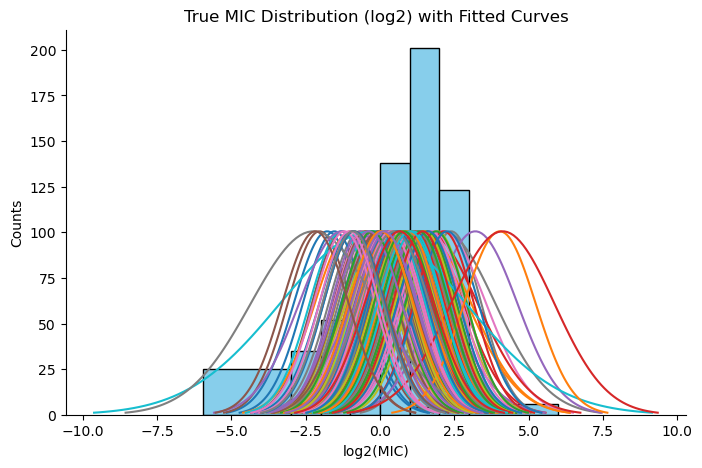

In [28]:
intervals = [(low, high) for low, high in zip(y_low_log, y_high_log)]

# Get unique intervals
unique_intervals = sorted(set(intervals))
# Calculate counts for each unique interval
mic_counts = [intervals.count(interval) for interval in unique_intervals]
# Extract the midpoints of the unique intervals for plotting
interval_midpoints = [(low + high) / 2 for low, high in unique_intervals]
# Extract widths for the bars (log2MIC range of each interval)
interval_widths = [high - low for low, high in unique_intervals]

plt.figure(figsize=(8, 5))
plt.bar(interval_midpoints, height=mic_counts, width=interval_widths,
        align='center', edgecolor='black', color='skyblue', label='True MIC Distribution')

for _, row in w_wt_bfgs.iterrows():
    effect_size = row['Effect_Size']  # This is the log2(MIC) mean from the model
    effect_std = row['Effect_Std']    # This is the log2(MIC) std from the model
    
    # Generate the x-values for the fitted curve (log2 scale)
    x_values = np.linspace(effect_size - 3*effect_std, effect_size + 3*effect_std, 100)
    
    # Generate the normal distribution using effect size and std (fitted mean and std)
    y_values = norm.pdf(x_values, loc=effect_size, scale=effect_std)
    
    # Scale the normal distribution to match the height of the histogram
    y_values *= (max(mic_counts) / max(y_values))/2
    
    plt.plot(x_values, y_values, label=f'Fitted {row["Mutation"]}', linestyle='-')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('log2(MIC)')
plt.ylabel('Counts')
plt.title('True MIC Distribution (log2) with Fitted Curves')


In [29]:
unique_ids = mgit.UNIQUEID.unique().tolist()

# Assuming y_low is an array that has the same length as the unique UNIQUEIDs
# Create the mapping
id_to_y_low = {unique_ids[id]: y_low_log[id] for id in range(len(unique_ids))}
id_to_y_high = {unique_ids[id]: y_high_log[id] for id in range(len(unique_ids))}
mgit['y_low_log'] = mgit['UNIQUEID'].map(id_to_y_low)
mgit['y_high_log'] = mgit['UNIQUEID'].map(id_to_y_high)

mut_y_low_log = {mut: mgit.loc[mgit['MUTATION'] == mut, 'y_low_log'].to_numpy() 
                 for mut in mgit['MUTATION'].unique()}
mut_y_high_log = {mut: mgit.loc[mgit['MUTATION'] == mut, 'y_high_log'].to_numpy() 
                 for mut in mgit['MUTATION'].unique()}

In [ ]:
#Convert to catalogue
ecoff = 1
labels = []
for i in w_wt_bfgs.index:
    z = (w_wt_bfgs['MIC'][i] - ecoff) / w_wt_bfgs['MIC_Std'][i]
    if abs(z) > 1.96: 
        if w_wt_bfgs['MIC'][i] < ecoff:
            labels.append('S')
        else:
            labels.append('R')
    else:
        labels.append('I')

w_wt_bfgs['LABEL'] = labels

In [30]:
w_wt_bfgs

,Mutation,Effect_Size,Effect_Std,MIC,MIC_Std
0,Rv0678@-7_indel,0.891353,1.079131,1.854914,1.387470
1,Rv0678@128_indel,0.232464,1.004368,1.174839,0.817893
2,Rv0678@130_indel,0.044403,1.225772,1.031256,0.876197
3,Rv0678@132_indel,1.434872,1.378575,2.703581,2.583421
4,Rv0678@133_indel,1.189318,1.020776,2.280449,1.613528
...,...,...,...,...,...
213,pepQ@Q5!,0.654857,1.170981,1.574460,1.277929
214,pepQ@S200L,0.124195,1.099960,1.089900,0.830977
215,pepQ@S66P,-2.172641,1.119720,0.221804,0.172149
216,pepQ@V102I,-1.033755,1.008541,0.488437,0.341451


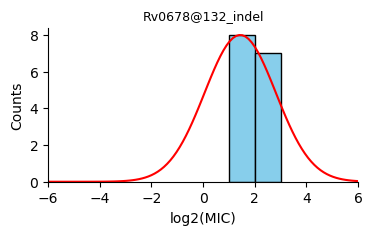

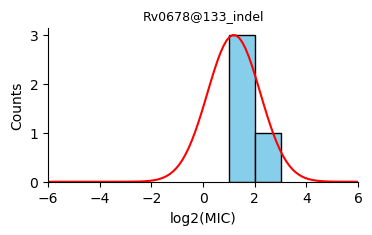

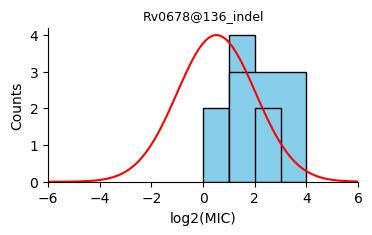

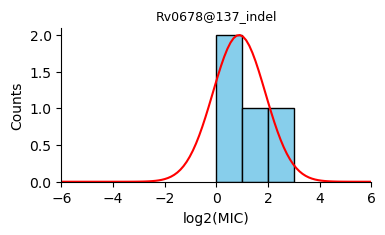

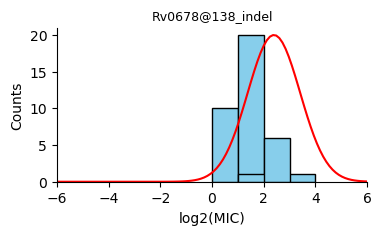

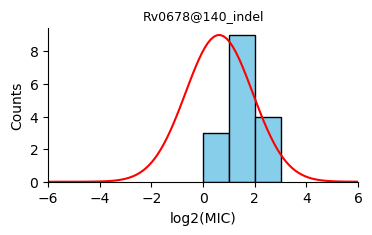

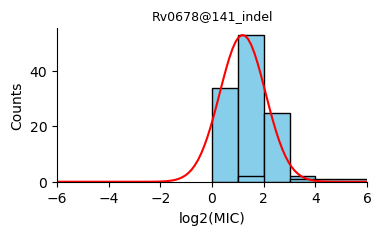

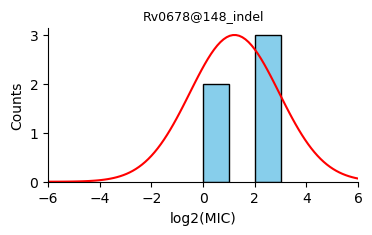

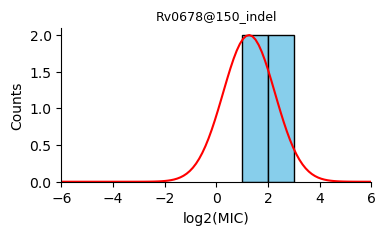

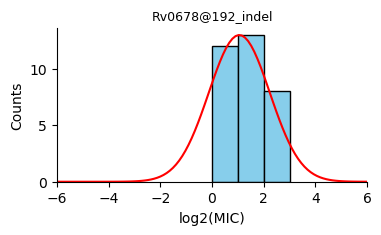

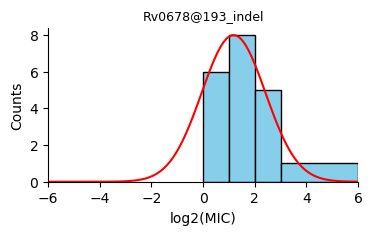

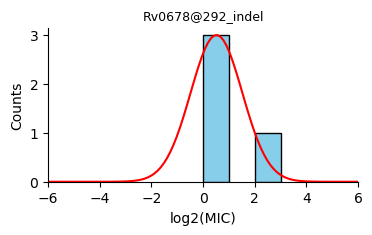

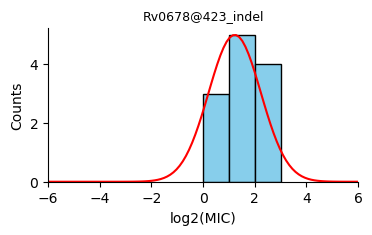

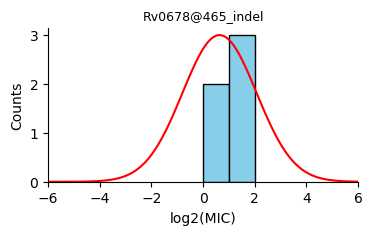

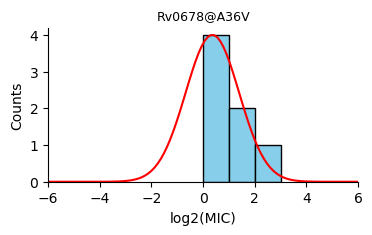

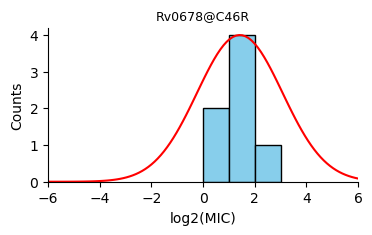

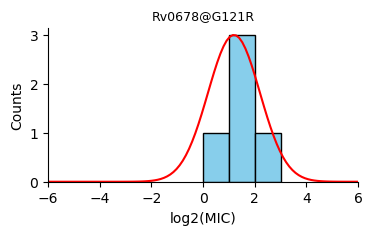

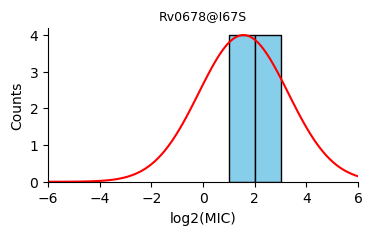

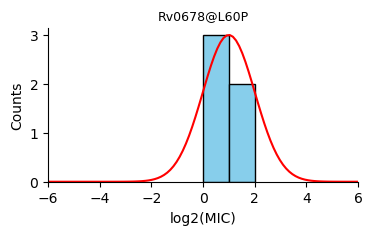

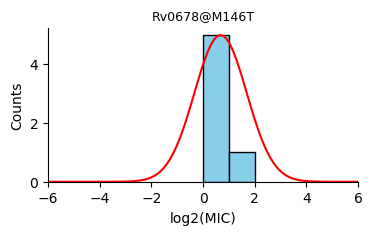

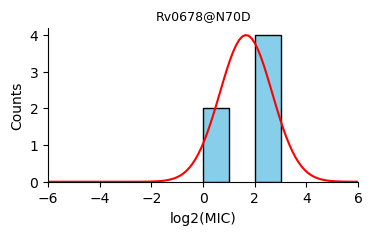

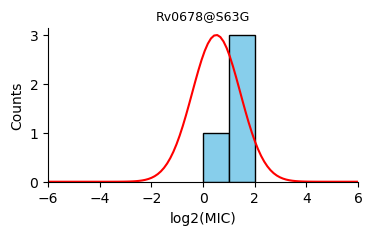

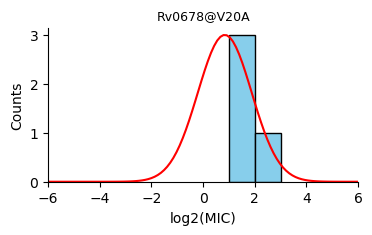

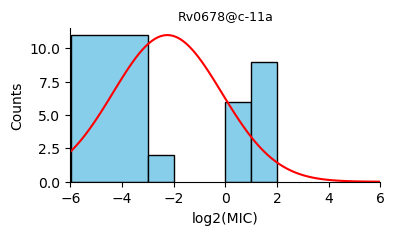

In [31]:
global_x_min = -6
global_x_max = 6

for _, row in w_wt_bfgs.iterrows():
    mutation_name = row['Mutation']
    effect_size = row['Effect_Size']  # log2MIC mean for the mutation
    effect_std = row['Effect_Std']    # log2MIC standard deviation for the mutation

    if len(mut_y_low_log[mutation_name])>3:

        # Get the mutation-specific MIC intervals
        mutation_y_low_log = mut_y_low_log[mutation_name]
        mutation_y_high_log = mut_y_high_log[mutation_name]

        # Combine the low and high log2 MIC values into interval tuples for the current mutation
        mutation_intervals = [(low, high) for low, high in zip(mutation_y_low_log, mutation_y_high_log)]

        # Get unique intervals for the current mutation
        unique_intervals = sorted(set(mutation_intervals))

        # Calculate counts for each unique interval
        mutation_mic_counts = [mutation_intervals.count(interval) for interval in unique_intervals]

        # Extract the midpoints and widths for plotting the bars
        interval_midpoints = [(low + high) / 2 for low, high in unique_intervals]
        interval_widths = [high - low for low, high in unique_intervals]

        plt.figure(figsize=(4, 2))  # Create a new figure for each mutation
        
        # Step 1: Plot the histogram of calculated MIC intervals for this mutation
        plt.bar(interval_midpoints, height=mutation_mic_counts, width=interval_widths,
                align='center', edgecolor='black', color='skyblue', label='True MIC Distribution')

        # Step 2: Overlay the fitted normal distribution for the current mutation
        x_values = np.linspace(global_x_min, global_x_max, 100)
        
        # Generate the normal distribution using effect size and std (fitted mean and std)
        y_values = norm.pdf(x_values, loc=effect_size, scale=effect_std)
        
        # Scale the normal distribution to match the height of the histogram
        y_values *= max(mutation_mic_counts) / max(y_values)
        
        # Plot the fitted curve
        plt.plot(x_values, y_values, label=f'Fitted Curve for {mutation_name}', linestyle='-', color='red')
        
        # Customize the plot
        plt.xlabel('log2(MIC)')
        plt.ylabel('Counts')
        plt.title(f'{mutation_name}', fontsize=9)  # Smaller font size
        plt.xlim([global_x_min, global_x_max])  # Set the consistent x-axis range
        
        # Remove top and right spines
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show the plot for this mutation
        plt.show()

I think weve got something that makes sense here - now need to clean up and maybe turn into a class. Can then test on other drugs (or should maybe do that first...)

# Other Drugs

In [14]:
phenos = pd.read_pickle('../cryptic-tables-v2.1.1/DST_MEASUREMENTS.pkl.gz').reset_index()
phenos = phenos[phenos.QUALITY=='HIGH']
genomes = pd.read_pickle('../cryptic-tables-v2.1.1/GENOMES.pkl.gz').reset_index()

In [15]:
drugs = {
    "INH": {"genes": ["inhA", "katG", "fabG1"], "seed": {"katG@R463L": "S"}},
    "RIF": {"genes": ["rpoA", "rpoB", "rpoC"], "seed": {}},
    "KAN": {"genes": ["rrs", "eis"], "seed": {}},
    "AMI": {"genes": ["rrs", "eis"], "seed": {}},
    "MXF": {"genes": ["gyrA", "gyrB"], "seed": {"gyrA@E21Q": "S"}},
    "EMB": {"genes": ["embB"], "seed": {}},
    "LEV": {
        "genes": ["gyrA", "gyrB"],
        "seed": {"gyrA@S95T": "S", "gyrA@E21Q": "S", "gyrA@G668D": "S"},
    },
    "LZD": {"genes": ["rplC", "rrl"], "seed": {}},
    # "STM": {"genes": ["rrs", "gid", "rpsL"], "seed": {}},
    "DLM": {"genes": ["ddn", "fbiA", "fbiC", "fbiB"], "seed": {}},
    "ETH": {"genes": ["inhA", "ethA"], "seed": {}},
}

dfs = {}

for drug, genes in drugs.items():
    print(drug)
    if not os.path.exists(
        f"./data/ignore/cryptic_drugs_v2.1.1/{drug.lower()}_mutations.csv"
    ):
        mutations = pd.read_pickle(
            "../cryptic-tables-v2.1.1/MUTATIONS.pkl.gz"
        ).reset_index()
        mutations = mutations[mutations.GENE.isin(genes["genes"])]
        mutations.to_csv(
            f"./data/ignore/cryptic_drugs_v2.1.1/{drug.lower()}_mutations.csv"
        )

    mutations = pd.read_csv(
        f"./data/ignore/cryptic_drugs_v2.1.1/{drug.lower()}_mutations.csv"
    )

    mutations["MUTATION"] = mutations.apply(
        lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
        axis=1,
    )
    mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
        lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
    )
    mutations["IS_NULL"] = mutations["MUTATION"].apply(
        lambda x: x.split("@")[-1][-1] == "Z"
    )
    mutations["FRS"] = mutations.apply(
        lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
    )

    phenotypes = phenos[phenos.DRUG == drug]
    ukmyc5_phenos = (
        phenotypes[phenotypes.METHOD_3 == "UKMYC5"]
        .groupby("UNIQUEID", group_keys=False)
        .apply(utils.filter_multiple_phenos)
    )
    ukmyc6_phenos = (
        phenotypes[phenotypes.METHOD_3 == "UKMYC6"]
        .groupby("UNIQUEID", group_keys=False)
        .apply(utils.filter_multiple_phenos)
    )

    ukmyc5_samples = pd.merge(ukmyc5_phenos, genomes, how="inner", on=["UNIQUEID"])
    ukmyc6_samples = pd.merge(ukmyc6_phenos, genomes, how="inner", on=["UNIQUEID"])

    ukmyc5 = pd.merge(mutations, ukmyc5_samples, how="right", on=["UNIQUEID"])
    ukmyc6 = pd.merge(mutations, ukmyc6_samples, how="right", on=["UNIQUEID"])

    ukmyc5.dropna(subset=["METHOD_MIC"], inplace=True)
    ukmyc6.dropna(subset=["METHOD_MIC"], inplace=True)

    ukmyc5["GENE"].fillna("None", inplace=True)
    ukmyc6["GENE"].fillna("None", inplace=True)

    ukmyc5_wts = ukmyc5[
        ukmyc5.UNIQUEID.isin(
            i
            for i in ukmyc5.UNIQUEID.unique()
            if (
                len(ukmyc5[ukmyc5.UNIQUEID == i]) == 1
                and ukmyc5.loc[ukmyc5.UNIQUEID == i, "IS_SYNONYMOUS"].iloc[0]
            )
            or pd.isna(ukmyc5.loc[ukmyc5.UNIQUEID == i, "MUTATION"].iloc[0])
        )
    ]

    ukmyc6_wts = ukmyc6[
        ukmyc6.UNIQUEID.isin(
            i
            for i in ukmyc6.UNIQUEID.unique()
            if (
                len(ukmyc6[ukmyc6.UNIQUEID == i]) == 1
                and ukmyc6.loc[ukmyc6.UNIQUEID == i, "IS_SYNONYMOUS"].iloc[0]
            )
            or pd.isna(ukmyc6.loc[ukmyc6.UNIQUEID == i, "MUTATION"].iloc[0])
        )
    ]

    ukmyc5_mutants = ukmyc5[~ukmyc5.UNIQUEID.isin(ukmyc5_wts.UNIQUEID)]
    ukmyc6_mutants = ukmyc6[~ukmyc6.UNIQUEID.isin(ukmyc6_wts.UNIQUEID)]

    dfs[drug] = {
        "UKMYC5": {"wt": ukmyc5_wts, "mutant": ukmyc5_mutants},
        "UKMYC6": {"wt": ukmyc6_wts, "mutant": ukmyc6_mutants},
    }

INH
RIF
KAN
AMI
MXF
EMB
LEV
LZD
DLM
ETH


In [16]:
wt = dfs['RIF']['UKMYC5']['wt']
mutants = dfs['RIF']['UKMYC5']['mutant']
data = pd.concat([mutants, wt])

#all_mutations = pd.read_pickle('../cryptic-tables-v2.1.1/MUTATIONS.pkl.gz').reset_index()
#all_mutations = all_mutations[all_mutations.UNIQUEID.isin(data.UNIQUEID)]
#all_mutations.to_csv('./data/ignore/rif_all_samples.csv')

all_mutations = pd.read_csv("./data/ignore/rif_all_samples.csv", index_col=0)
cluster_ids = cluster_coordinates(all_mutations, data, distance=100)

X = build_X(data)
#convert sample MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(data.drop_duplicates(subset='UNIQUEID', keep='first'))
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_49061/1402528351.py:9: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  all_mutations = pd.read_csv("./data/ignore/rif_all_samples.csv", index_col=0)


In [52]:
#initialise coefficients and standard deviation
# Number of fixed effects
p = X.shape[1]

# Number of random effects (equal to number of unique clusters)
#r = Z.shape[1]

n_clusters = len(np.unique(cluster_ids))
initial_random_effects = np.zeros(n_clusters)  # One random effect per cluster

initial_beta = np.random.normal(loc=0, scale=0.5, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)

# Combine initial values for the parameters
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

fixed_effect_bounds = [(-6, 6)] * X.shape[1]
random_effect_bounds = [(None, None)] * n_clusters
sigma_bound = [(1e-5, None)]
bounds = fixed_effect_bounds + random_effect_bounds + sigma_bound

In [55]:
cluster_ids.tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


Revisit Josh's data and see if i cant replicate, and how much variance there is around that. Perhaps even plot his output against his distributions - compare to ours to see how off his model is.

### Try Josh's data 

In [ ]:
df = pd.read_csv('./data/ignore/Josh_input.csv')

In [ ]:
df[df.Rv0678_138_indel==1]

,mmpL5_G246S,mmpL5_H437R,Rv3249c_E185E,Rv3249c_V210V,mmpL5_G759S,Rv0678_I108T,mmpL5_I732V,mmpL5_Y586Y,mmpL5_E723D,mmpL5_A359T,...,LINEAGE,SITEID,UNIQUEID,PLATEDESIGN,LOG2MIC,UPLOG2MIC,cluster12,cluster25,cluster50,cluster100
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.XG00534041.lab.XG00534041.iso.1,UKMYC6,-3.06,-2.00,4824,518,173,619
2323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,3,site.03.subj.DR-141.lab.IML-01116.iso.1,UKMYC6,-4.06,-3.06,8214,8214,104,4806
3597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.UH01208742.lab.UH01208742.iso.1,UKMYC6,-3.06,-2.00,1257,543,474,816
4347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.YA00038901.lab.YA00038901.iso.1,UKMYC5,-3.06,-2.00,192,543,474,816
4907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.YA00020529.lab.YA00020529.iso.1,UKMYC5,-3.06,-2.00,658,543,474,816
5382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.YA00040363.lab.YA00040363.iso.1,UKMYC5,-3.06,-2.00,192,543,474,816
6691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,10,site.10.subj.NM00830377.lab.NM00830377.iso.1,UKMYC6,-4.06,-3.06,1983,3968,195,248


In [ ]:
X = df[df.columns[:227]]

y_low_log, y_high_log = df.LOG2MIC, df.UPLOG2MIC

cluster_ids = df.cluster100

unique_clusters = np.unique(cluster_ids)
cluster_map = {old_id: new_id for new_id, old_id in enumerate(unique_clusters)}
cluster_ids = cluster_ids.map(cluster_map)

p = X.shape[1]

# Number of random effects (equal to number of unique clusters)
#r = Z.shape[1]

n_clusters = len(np.unique(cluster_ids))
initial_random_effects = np.zeros(n_clusters)  # One random effect per cluster

initial_beta = np.random.normal(loc=0, scale=0.5, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)

# Combine initial values for the parameters
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

result = minimize(
    log_likelihood_mixed_effects, 
    initial_params, 
    args=(y_low_log, y_high_log, X, cluster_ids),
    method='L-BFGS-B',
    bounds = [(None, None)] * (X.shape[1] + n_clusters) + [(1e-7, None)],  # Adjust bounds for the random effects and sigma
    options={'maxiter': 100000, 'maxfun': 500000}  # Increase the max iterations and function evaluations
)

In [ ]:
# Extract only the first p elements of the result, which correspond to the mutation effects
fixed_effects_coefficients = result.x[:p]

# Sigma (standard deviation)
sigma = result.x[-1]

# Create DataFrame for mutation effects
mutation_effects = pd.DataFrame({
    'Mutation': X.columns,  # The names of the mutations from X
    'Effect_Size': fixed_effects_coefficients
})

# Convert effect sizes to MIC values (by reversing the log transformation)
mutation_effects['MIC'] = 2**mutation_effects['Effect_Size']

if hasattr(result, 'hess_inv'):
    hess_inv_dense = result.hess_inv.todense()  # Convert to a dense matrix
    # Extract the diagonal elements corresponding to the fixed effects (log2(MIC) scale)
    effect_std_log2 = np.sqrt(np.diag(hess_inv_dense)[:p])  # Standard deviation of log2(MIC)
    mutation_effects['Effect_Std_Log2'] = effect_std_log2
    # Convert standard deviation to MIC scale
    mutation_effects['MIC_Std'] = mutation_effects['MIC'] * np.log(2) * mutation_effects['Effect_Std_Log2']

# Output the mutation catalogue
mutation_effects = mutation_effects[['Mutation', 'Effect_Size', 'MIC', 'MIC_Std']]


In [ ]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 11588.85028095283
        x: [-2.307e+00 -6.124e-01 ...  5.727e-01  1.028e+00]
      nit: 110
      jac: [ 9.909e+00 -2.281e+00 ... -9.222e-01  2.069e+02]
     nfev: 427192
     njev: 134
 hess_inv: <3187x3187 LbfgsInvHessProduct with dtype=float64>

In [ ]:
mutation_effects

,Mutation,Effect_Size,MIC,MIC_Std
0,mmpL5_G246S,-2.306895,0.202095,0.292751
1,mmpL5_H437R,-0.612418,0.654100,0.830609
2,Rv3249c_E185E,0.563073,1.477412,1.484313
3,Rv3249c_V210V,1.193833,2.287597,2.117410
4,mmpL5_G759S,-0.566625,0.675194,0.468198
...,...,...,...,...
222,Rv0678_234_indel__Rv3249c_625_indel,-0.535471,0.689933,0.766849
223,mmpL5_L836F__mmpL5_Y690Y,-0.793121,0.577094,0.402140
224,pepQ_L265L__mmpL5_W936R,-1.492254,0.355457,0.598416
225,LINEAGE,-1.425932,0.372179,0.232481


In [ ]:
mutation_effects[mutation_effects.Mutation=='Rv0678_138_indel']

,Mutation,Effect_Size,MIC


In [ ]:
n_clusters

4991

In [ ]:
result


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 90796.15672825587
        x: [ 1.301e-01  4.287e-02 ...  0.000e+00  6.873e-01]
      nit: 1
      jac: [ 2.821e+02  3.155e+01 ...  2.322e+00 -2.200e+05]
     nfev: 9564
     njev: 3
 hess_inv: <3187x3187 LbfgsInvHessProduct with dtype=float64>